# Akcja segmentacja

Segmentację klientów przeprowadzę metodą `k-średnich`.

## Import i obróbka danych

In [1]:
# Import bibliotek
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



# Wczytanie danych Customers.csv jako ramka danych
df = pd.read_csv('Customers.csv', sep = ';')

# Wyświetlenie pierwszych 5 wierszy danych, typu danych
print(df.head())

print(df.dtypes)

   CustomerId  Profit  Recency  Frequency  Monetary  Variance
0           1     187       63          1   2349,06         2
1           2      96       10          6    922,62         4
2           3      47       35          4    881,22         3
3           4     294        5          1   3815,16         2
4           5     732        4         31  41868,11        29
CustomerId     int64
Profit         int64
Recency        int64
Frequency      int64
Monetary      object
Variance       int64
dtype: object


Zmienna `Monetary` jest typu `object`, na których nie da się przeprowadzić obliczeń. Z tego powodu zmienię jej typ na `float`. Sprawdzę również czy występują braki danych.

In [2]:
# Sprawdzenie braków danych
print(df.isnull().values.any())

False


Nie występują braki danych.

In [3]:
# Zamiana przecinków na kropki w kolumnie Monetary
df['Monetary']=df['Monetary'].str.replace(',','.')
# Zamiana klomuny Monetary na typ numeryczny
df['Monetary'] = df['Monetary'].astype(float)
print(df.dtypes)
print(df.head())

CustomerId      int64
Profit          int64
Recency         int64
Frequency       int64
Monetary      float64
Variance        int64
dtype: object
   CustomerId  Profit  Recency  Frequency  Monetary  Variance
0           1     187       63          1   2349.06         2
1           2      96       10          6    922.62         4
2           3      47       35          4    881.22         3
3           4     294        5          1   3815.16         2
4           5     732        4         31  41868.11        29


Teraz już wszystkie zmienne są typu numerycznego, więc mogę wyświetlić podstawowe statystyki zmiennych.

In [4]:
# Skopiowanie ramki danych do późniejszych analiz
df1 = df.copy()

# Wyświetlenie podstawowych statystyk
df1 = df1.drop('CustomerId', axis = 1)
print(df1.describe().round(2))

          Profit  Recency  Frequency     Monetary  Variance
count    1511.00  1511.00    1511.00      1511.00   1511.00
mean     1102.39    15.85      10.71    175380.50     16.67
std      5457.68    19.05      10.35   1791089.38     17.70
min         1.00     1.00       1.00         7.29      1.00
25%        79.00     4.00       3.00      1392.95      5.00
50%       224.00     6.00       9.00      5799.93     11.00
75%       559.50    19.00      14.50     22289.00     23.00
max    105993.00    91.00      79.00  32539936.23    139.00


Jak możemy zauważyć średnie oraz odchylenia standardowe zmiennych `Profit` oraz `Monetary` różnią się znacząco od średnich oraz odchylenia standardowego pozostałych zmiennych. Może to prowadzić do błędnego przyporządkowania klientów do poszczególnych grup tak jak niesymetryczny rozkład zmiennych. Rozkład zmiennych sprawdzę na wykresach.

## Wstępna analiza i przygotowanie danych 

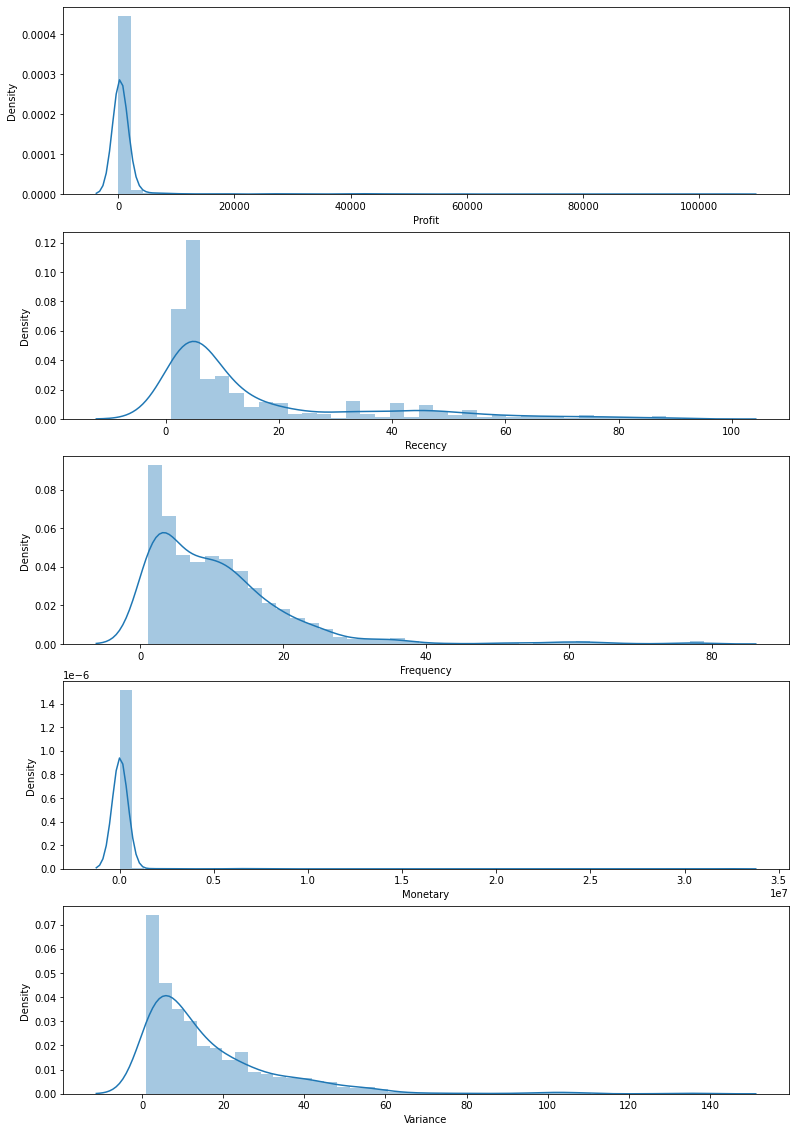

In [5]:
# Wykresy rozkładu zmiennych
plt.figure(figsize=(13, 20))
plt.subplot(5, 1, 1); sns.distplot(df1['Profit'])
plt.subplot(5, 1, 2); sns.distplot(df1['Recency'])
plt.subplot(5, 1, 3); sns.distplot(df1['Frequency'])
plt.subplot(5, 1, 4); sns.distplot(df1['Monetary'])
plt.subplot(5, 1, 5); sns.distplot(df1['Variance'])
plt.show()

Z wykresów możemy zauważyć, że wszystkie zmienne mają rozkład `prawoskośny`. Do poprawnego działania modelu `k-średnich` oraz poprawnego przyporządkowana do grup rozkłady powinny być jak najbardziej symetryczne. W tym celu przeprowadzę transformację zmiennych. Wykorzystam transformację `logarytmiczną`. Z podstawowych statystyk możemy zauważyć, że wszystkie zmienne są dodatnie i nic nie stoi na przeszkodzie do użycia transformacji logarytmicznej. 

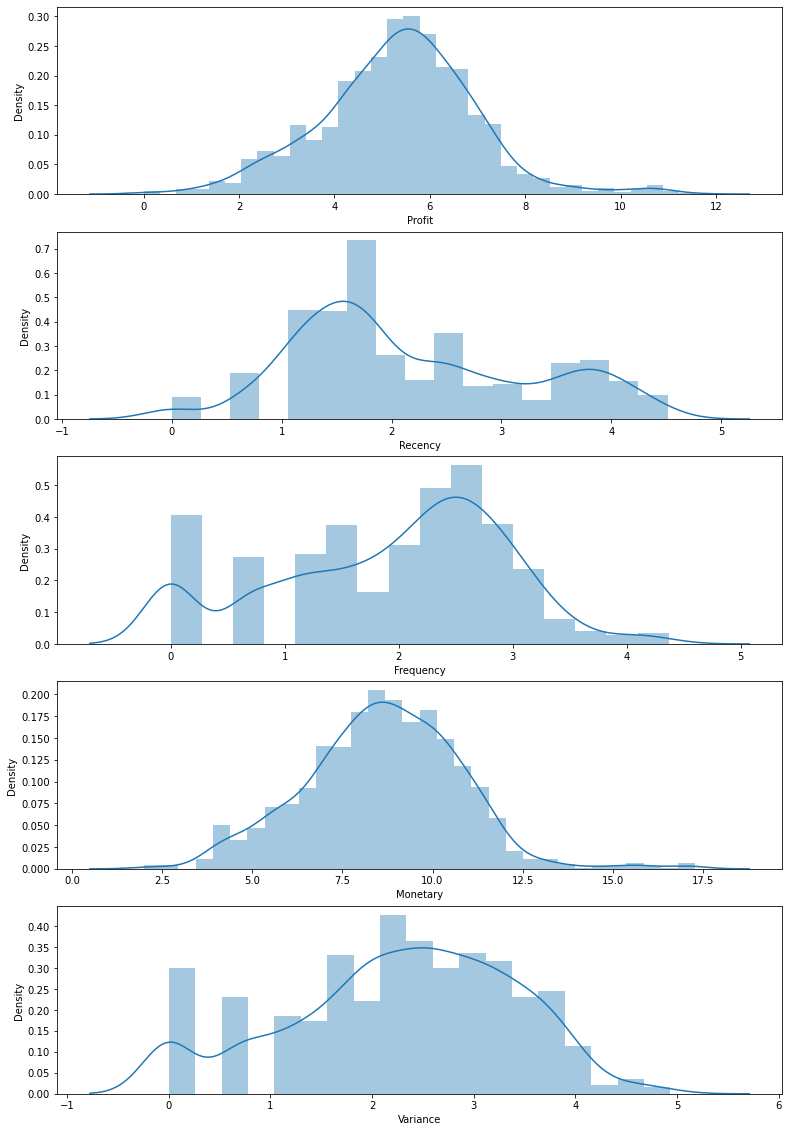

In [6]:
# Transformacja zmiennych 
(df1['Profit']) = np.log(df1['Profit'])
(df1['Recency']) = np.log(df1['Recency'])
(df1['Frequency']) = np.log(df1['Frequency'])
(df1['Monetary']) = np.log(df1['Monetary'])
(df1['Variance']) = np.log(df1['Variance'])


# Nowe wykresy rozkładu
plt.figure(figsize=(13, 20))
plt.subplot(5, 1, 1); sns.distplot(df1['Profit'])
plt.subplot(5, 1, 2); sns.distplot(df1['Recency'])
plt.subplot(5, 1, 3); sns.distplot(df1['Frequency'])
plt.subplot(5, 1, 4); sns.distplot(df1['Monetary'])
plt.subplot(5, 1, 5); sns.distplot(df1['Variance'])
plt.show()

Po przeprowadzeniu tranformacji nasze dane wyglądają lepiej i nadają się do użycia w metodzie `k-średnich`. Rozkłady są podobne do symetrycznego. Jak wcześniej wspomniałem danę mają różne średnie i odchylenia standardowe, więc moim kolejnym krokiem będzie ich normalizacja.

In [7]:
# Normalizacja danych
scaler = StandardScaler()
scaler.fit(df1)
df_normalized = scaler.transform(df1)
df_normalized = pd.DataFrame(df_normalized, index = df1.index, columns = df1.columns)
print(df_normalized.describe().round(2))

        Profit  Recency  Frequency  Monetary  Variance
count  1511.00  1511.00    1511.00   1511.00   1511.00
mean      0.00     0.00       0.00     -0.00      0.00
std       1.00     1.00       1.00      1.00      1.00
min      -3.29    -2.02      -1.89     -3.07     -2.04
25%      -0.59    -0.72      -0.82     -0.64     -0.60
50%       0.05    -0.35       0.26      0.02      0.10
75%       0.61     0.73       0.73      0.65      0.76
max       3.84     2.19       2.39      4.03      2.37


Po normalizacji dane mają średnią bliską `0` oraz odchylenie standardowe bliskie `1` co oznacza, że są odpowiednie do użycia w metodzie `k-średnich`. Po transformacji oraz normalizacji dane gotowe są do stworzenia modelu. Narysuję wykres sumy kwadratów błędu standardowego dla poszczególnych `k` z zakresu od `1` do `10`. Jest to tak zwany wykres osypiska, z którego dobiorę odpowiednią liczbę grup.

## Stworzenie modelu `k-średnich`

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


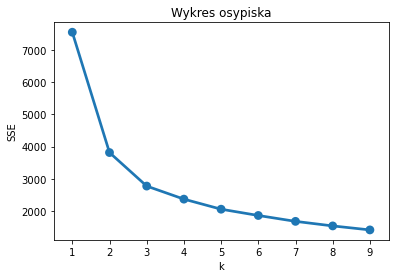

In [8]:
sse = {}
for k in range(1, 10):
  
    # KMeans dla k grup
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Dopasowanie modelu do danych znormalizowanych
    kmeans.fit(df_normalized)
    
    # Dodanie SSE dla k do słownika sse
    sse[k] = kmeans.inertia_

# Narysowanie wykresu osypiska
plt.title('Wykres osypiska'); plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Z wykresu osypiska możemy zauważyć, że suma kwadratów błędu standardowego dla `k=4` i wyższych maleje nieznacznie. Najbardziej odpowiedni model będzie dla `k=3`. Stworzę model `KMeans` dla `k=3` oraz przedstawię średnie poszczególnych zmiennych dla podanych grup.

In [9]:
# Użycie KMeans dla k = 3
kmeans = KMeans(n_clusters = 3, random_state=1) 

# Dopasowanie danych do modelu
kmeans.fit(df_normalized)

# Wyeksportowanie nazw grup z modelu
cluster_labels = kmeans.labels_

# Stworzenie ramki danych z pierwotnymi danymi oraz segmentacją
df_k3 = df.assign(SegmentId = cluster_labels)

# Grupowanie danych 
grouped = df_k3.groupby(['SegmentId'])

# Podstawowe statystyki dla zmiennych ze względu na grupy
grouped.agg({
    'CustomerId' : 'count',
    'Profit': 'mean',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Variance': 'mean',
  }).round(1)


,CustomerId,Profit,Recency,Frequency,Monetary,Variance
SegmentId,,,,,,
0,565,2668.9,5.8,18.6,462192.5,32.6
1,321,56.4,40.1,1.9,930.9,2.6
2,625,223.5,12.5,8.1,5699.8,9.6


Text(0.5, 1.0, 'Mediana Profit w segmentach')

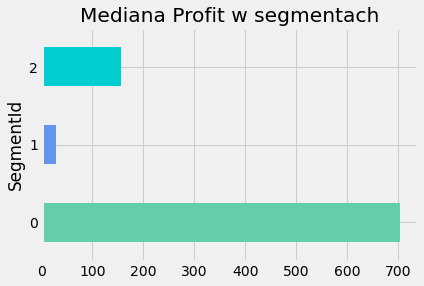

In [10]:
plt.style.use('fivethirtyeight')
grouped['Profit'].median().plot.barh(color = ['mediumaquamarine', 'cornflowerblue', 'darkturquoise'])
plt.title('Mediana Profit w segmentach')

Text(0.5, 1.0, 'Mediana Recency w segmentach')

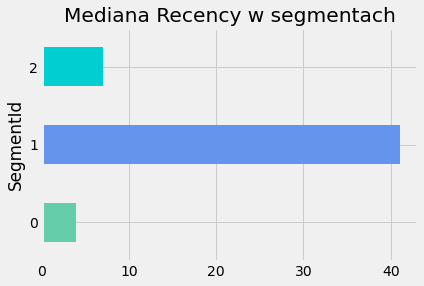

In [11]:
grouped['Recency'].median().plot.barh(color = ['mediumaquamarine', 'cornflowerblue', 'darkturquoise'])
plt.title('Mediana Recency w segmentach')

Text(0.5, 1.0, 'Mediana Frequency w segmentach')

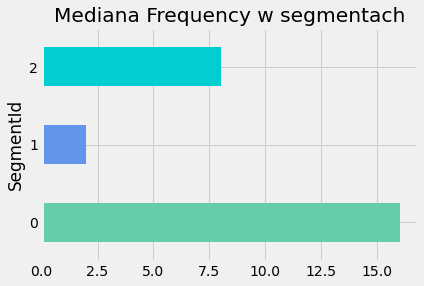

In [12]:
grouped['Frequency'].median().plot.barh(color = ['mediumaquamarine', 'cornflowerblue', 'darkturquoise'])
plt.title('Mediana Frequency w segmentach')

Text(0.5, 1.0, 'Mediana Monetary w segmentach')

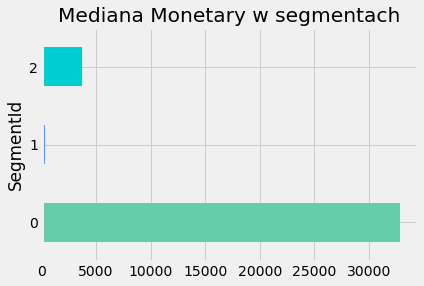

In [13]:
grouped['Monetary'].median().plot.barh(color = ['mediumaquamarine', 'cornflowerblue', 'darkturquoise'])
plt.title('Mediana Monetary w segmentach')

Text(0.5, 1.0, 'Mediana Variance w segmentach')

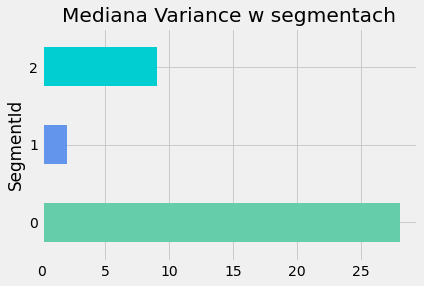

In [14]:
grouped['Variance'].median().plot.barh(color = ['mediumaquamarine', 'cornflowerblue', 'darkturquoise'])
plt.title('Mediana Variance w segmentach')

## Wnioski

Segmenty klientów:
 - Pierwszą grupę klientów oznaczoną jako `0` nazwałbym `Lojalny`. Jest to druga co do wielkości grupa klientów. Kupują oni bardzo często, średnia ilość dni od ostatniego zakupu jest najmniejsza i wynosi niecałe `6` dni. Różnorodność zakupionych produktów jest największa w tej grupie, wynosi powyżej `30`. Klienci w tej w grupie wydali najwięcej pieniędzy na produkty firmy. Jest to grupa klientów, którzy kupują często i dużo w danej firmie.
 - Drugą grupę klientów oznaczoną jako `1` nazwałbym `Przypadkowy`. Jest to najmniej liczna grupa klientów. Kupują oni średnio tylko `2` produkty, ilość dni od ostatniego zakupu jest bardzo duża, a częstotliwość zakupowa bardzo mała. Są to klienci, którzy najprawdopodobniej szukali jakiegoś produktu i kupili go w danej firmie ale nie zostali na dłużej. Nie przynieśli oni dużych zysków.
 - Trzecią grupę klientów oznaczoną jako `2` nazwałbym `Stały`. Jest to najbardziej liczna grupa klientów. Kupują oni średnio prawie `10` różnorodnych produktów. Częstotliwość zakupów jest dwa razy mniejsza niż w grupie lojalnych klientów, a ilość dni od ostatniego zakupu dwa razy większa. Klienci z tej grupy nie przynieśli tak dużych zysków jak `Lojalni`.

Pamiętając o prawoskośności rozkładów zmiennych i porównując tabelkę ze średnimi oraz wykresy median w grupach możemy zauważyć, że zmienne `Profit` oraz `Monetary` mają dużo niższą medianę w porównaniu do średniej w grupie `Lojalny`. Wynika to z faktu, że w tej grupie jest część klientów, którzy wydali dużo więcej pieniędzy niż reszta klientów w tej grupie. Dla pozostałych zmiennych w tej grupie oraz dla wszystkich zmiennych w pozostałych grupach mediana i średnia różnią się nieznacznie. Grupa `Przypadkowy` liczy `321` klientów co stanowi około `20%` wszystkich klientów. Dla firmy są to dobre wieści, ponieważ czterech klientów na pięciu zostają z firmą na stałe i kupują ich produkty. 

## Zapisanie ramki danych do pliku csv

In [15]:
# Stworzenie funkcji, która przyporządkuje nazwę segmentu do cyfry segmentu
def segment_name(df_k3):
    if df_k3['SegmentId'] == 0:
        return 'Lojalny'
    elif df_k3['SegmentId'] == 1:
        return 'Przypadkowy'
    else:
        return 'Staly'

# Stworzenie nowej kolumny SegmentName przy użyciu funkcji segment_name
df_k3['SegmentName'] = df_k3.apply(segment_name, axis=1)

print(df_k3.head())

   CustomerId  Profit  Recency  Frequency  Monetary  Variance  SegmentId  \
0           1     187       63          1   2349.06         2          1   
1           2      96       10          6    922.62         4          2   
2           3      47       35          4    881.22         3          1   
3           4     294        5          1   3815.16         2          2   
4           5     732        4         31  41868.11        29          0   

   SegmentName  
0  Przypadkowy  
1        Staly  
2  Przypadkowy  
3        Staly  
4      Lojalny  


In [16]:
# Zapisanie ramki danych do pliku Customers.csv
df_k3.to_csv (r'C:\Users\artur\Desktop\Customers.csv', index = False, header=True)